In [ ]:
# swin transformer model
!pip install -q timm torch torchvision scikit-learn seaborn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, shutil

# 👇 Change this path to your dataset folder inside Drive
base_dir = '/content/drive/MyDrive/oral_cancer_dataset'
# It should contain: Benign/, Healthy/, OCA/, OPMD/

merged_dir = '/content/oral_cancer_2class'
os.makedirs(os.path.join(merged_dir, 'Healthy'), exist_ok=True)
os.makedirs(os.path.join(merged_dir, 'Oral_Cancer'), exist_ok=True)

# Merge categories
for src_cls, dest_cls in [
    ('OCA', 'Oral_Cancer'),
    ('OPMD', 'Oral_Cancer'),
    ('Benign', 'Healthy'),
    ('Healthy', 'Healthy')
]:
    src = os.path.join(base_dir, src_cls)
    if os.path.exists(src):
        for f in os.listdir(src):
            src_path = os.path.join(src, f)
            dst_path = os.path.join(merged_dir, dest_cls, f'{src_cls}_{f}')
            if os.path.isfile(src_path):
                shutil.copy(src_path, dst_path)

for cls in os.listdir(merged_dir):
    print(cls, "→", len(os.listdir(os.path.join(merged_dir, cls))), "images")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Oral_Cancer → 1523 images
Healthy → 1478 images


In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image
import os

# Custom ImageFolder that skips corrupted images
class ImageFolderWithSkipped(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        try:
            img = self.loader(path)
        except (IOError, OSError) as e:
            print(f"Skipping corrupted image: {path}, error: {e}")
            # Return a placeholder or None, depending on how you want to handle it
            # Here, we'll return None and filter later
            return None, None
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

dataset = ImageFolderWithSkipped(merged_dir, transform=transform)

# Filter out skipped samples (where img is None)
valid_samples = [(img, label) for img, label in dataset if img is not None]

# Create a new dataset from valid samples
# This is a bit manual but handles the filtering after loading
# A more efficient way might involve creating a custom Dataset class
class FilteredListDataset(torch.utils.data.Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        return self.data_list[index]

filtered_dataset = FilteredListDataset(valid_samples)


train_size = int(0.8 * len(filtered_dataset))
val_size = len(filtered_dataset) - train_size
train_ds, val_ds = random_split(filtered_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

print("Classes:", dataset.classes)
print(f"Total images in filtered dataset: {len(filtered_dataset)}")
print(f"Train images: {len(train_ds)}, Validation images: {len(val_ds)}")

Skipping corrupted image: /content/oral_cancer_2class/Oral_Cancer/OPMD_N-260-01.jpg, error: image file is truncated (30 bytes not processed)
Classes: ['Healthy', 'Oral_Cancer']
Total images in filtered dataset: 3000
Train images: 2400, Validation images: 600


In [ ]:
import timm
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Device: cuda


In [ ]:
from sklearn.metrics import accuracy_score
import time

epochs = 8
for epoch in range(epochs):
    model.train()
    total, correct, train_loss = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(out, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss/len(train_loader):.4f} | Accuracy: {acc:.2f}%")


Epoch 1/8 | Loss: 0.6930 | Accuracy: 55.46%
Epoch 2/8 | Loss: 0.6592 | Accuracy: 61.38%
Epoch 3/8 | Loss: 0.6179 | Accuracy: 65.08%
Epoch 4/8 | Loss: 0.5405 | Accuracy: 72.54%
Epoch 5/8 | Loss: 0.4271 | Accuracy: 80.42%
Epoch 6/8 | Loss: 0.2814 | Accuracy: 88.12%
Epoch 7/8 | Loss: 0.1582 | Accuracy: 94.38%
Epoch 8/8 | Loss: 0.1552 | Accuracy: 94.12%


✅ Swin Transformer Performance:
Accuracy : 0.7583
Precision: 0.7799
Recall   : 0.7085
F1-Score : 0.7425

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.74      0.81      0.77       305
 Oral_Cancer       0.78      0.71      0.74       295

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.76       600
weighted avg       0.76      0.76      0.76       600



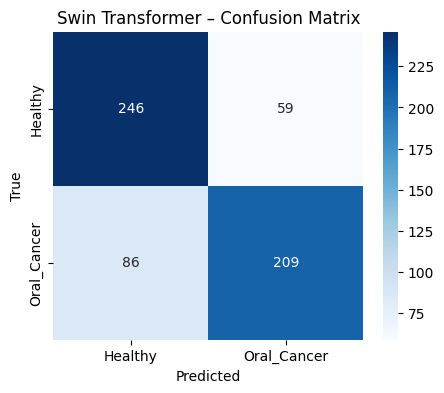

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        _, preds = torch.max(out, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("✅ Swin Transformer Performance:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Swin Transformer – Confusion Matrix')
plt.show()


In [ ]:
torch.save(model.state_dict(), '/content/swin_oral_cancer_model.pth')
print("✅ Model saved successfully!")


✅ Model saved successfully!
